# Testing Numerial Gradient

In this notebook I am trying to assess the validity of calculating the spectral slope using dy/dx.

In *Figueira et al. 2016* the slope is calculated as `dy/dx = np.diff(flux)/ np.diff(wav)`. The `np.diff()` function shrinks the array by 1 which can be significant when slicing the wavelengths into many chunks for the telluric masking. (each losing 1 pixel)

I am investigating the `np.gradient` function which returns the same sized array. 

From the documentation     
    - "The gradient is computed using second order accurate central differences in the interior points and either first or second order accurate one-sides (forward or backwards) differences at the boundaries. The returned gradient hence has the same shape as the input array."
    

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from eniric.utilities import load_aces_spectrum

/home/jneal/anaconda3/envs/eniric/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# from eniric.Qcalculator import slope, slope_grad

def slope(wavelength, flux):
    """Original version used to calculate the slope. [Looses one value of array]."""
    delta_flux = np.diff(flux)
    delta_lambda = np.diff(wavelength)

    return delta_flux / delta_lambda

def slope_grad(wavelength, flux):
    """Slope using gradient."""
    return np.gradient(flux, wavelength)  # Yes they should be opposite order

def slope_adjusted(wavelength, flux):
    """Slope that adjust the wave and flux values to match diff."""
    derivf_over_lambda = np.diff(flux) / np.diff(wavelength)
    wav_new = (wavelength[:-1] + wavelength[1:])/2
    flux_new = (flux[:-1] + flux[1:])/2
    return derivf_over_lambda, wav_new, flux_new

In [3]:
# Load spectrum 
wl_, flux_ = load_aces_spectrum([3900, 4.5, 0.0, 0])   # M0 star
wl_ = wl_*1000



Here we plot a small section of the spectrum and the slopes from the gradient and dy/dx methods.

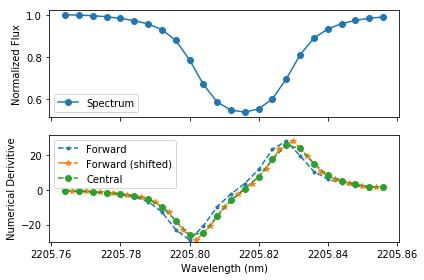

In [4]:
mask = ((wl_/1000) > 2.20576) & ((wl_/1000) < 2.20586)
wl, flux = wl_[mask], flux_[mask]
flux = flux / max(flux) # Normalize maximum to 1

f_slope = slope(wl, flux)
f_grad = slope_grad(wl, flux)
f_adj, new_wl, new_flux = slope_adjusted(wl, flux)

#plt.figure(figsize=(15,10))
ax1 = plt.subplot(211)
plt.plot(wl, flux, "o-", label="Spectrum")
#plt.plot(new_wl, new_flux, "+--", label="Diff adjusted")
plt.ylabel("Normalized Flux")
plt.ticklabel_format(axis="x", style="plain")
ax1.ticklabel_format
plt.legend()

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(wl[:-1], f_slope, ".--", label="Forward") 
plt.plot(new_wl, f_adj, "*-.", label="Forward (shifted)") 
plt.plot(wl, f_grad, "o--", label="Central")
plt.ylim([-30,32])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Numerical Derivitive")
ax2.ticklabel_format(useOffset=False)
ax1.tick_params(labelbottom=False)
plt.legend()
plt.tight_layout()
plt.savefig("spectra_gradient_example1.pdf")
plt.show()

There is an wavelength offset between the dy/dx (blue) and gradient (green) due to the wavelenght points. The wavelength and flux are adjusted to the center of each difference (orange).

We later show that the difference difference between the blue and orange creates a change in precision of around 0.1%. (e.g. the wavelength difference is squared)


The gradient is less sharp then the dy/dx method and so produces a lower precision (higher rms).
We also show that the difference in RV between the gradient and dy/dx method is between $2-7$% in the given bands!


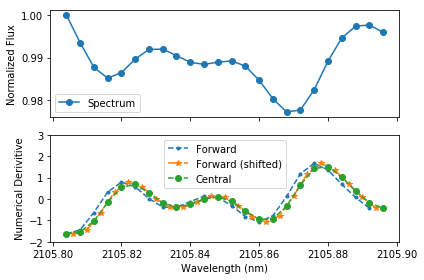

In [5]:
# Another example
mask = ((wl_/1000) > 2.10580) & ((wl_/1000) < 2.1059)

wl, flux = wl_[mask], flux_[mask]

flux = flux/max(flux)

f_slope = slope(wl, flux)
f_grad = slope_grad(wl, flux)
f_adj, new_wl, new_flux = slope_adjusted(wl, flux)

#plt.figure(figsize=(15,10))
ax1 = plt.subplot(211)
plt.plot(wl, flux, "o-", label="Spectrum")
# plt.plot(new_wl, new_flux, "+--", label="Diff adjusted")
plt.ylabel("Normalized Flux")

plt.legend()
ax2= plt.subplot(212, sharex=ax1)
plt.plot(wl[:-1], f_slope, ".--", label="Forward") 
plt.plot(new_wl, f_adj, "*-.", label="Forward (shifted)") 
plt.plot(wl, f_grad, "o--", label="Central")
plt.ylim([-2,3])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Numerical Derivitive")
ax2.ticklabel_format(useOffset=False)
ax1.tick_params(labelbottom=False)
plt.tight_layout()
plt.savefig("spectra_gradient_example2.pdf")
plt.legend()
plt.show()

In [6]:
# Gradient method is ~7 times slower than the difference.
%timeit np.diff(flux_)/np.diff(wl_)
%timeit np.gradient(wl_, flux_, axis=0)

13.4 ms ± 428 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
62 ms ± 285 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [7]:
# Functions to calcualte wis, and q and RV from the slopes.
def slope_wis(wavelength, flux):
    derivf_over_lambda = slope(wavelength, flux)
    wis = np.sqrt(
        np.nansum(
            wavelength[:-1] ** 2.0 * derivf_over_lambda ** 2.0 / flux[:-1]
        )
    )
    return wis

def grad_wis(wavelength, flux):
    derivf_over_lambda = slope_grad(wavelength, flux)

    wis = np.sqrt(
        np.nansum(
            wavelength ** 2.0 * derivf_over_lambda ** 2.0 / flux
        )
    )
    return wis

def slope_adjusted_wis(wavelength, flux):
    derivf_over_lambda, wav_new, flux_new = slope_adjusted(wavelength, flux)

    wis = np.sqrt(
        np.nansum(
            wav_new ** 2.0 * derivf_over_lambda ** 2.0 / flux_new
        )
    )
    return wis

def q(wavelength, flux):
    "Quality"
    return slope_wis(wavelength, flux) / np.sqrt(np.nansum(flux))

def grad_q(wavelength, flux):
    "Quality"
    return grad_wis(wavelength, flux) / np.sqrt(np.nansum(flux))

from astropy.constants import c
def slope_rv(wavelength, flux):
    return c.value / slope_wis(wavelength, flux)

def grad_rv(wavelength, flux):
    return c.value / grad_wis(wavelength, flux)

def slope_adjusted_rv(wavelength, flux):
    return c.value / slope_adjusted_wis(wavelength, flux)


# Numerical Gradient Effect on Bands
Need to calcualte the relative difference on the same wavelength and flux sections. They are all normalized differently due to the maximum in the given range.

In [8]:
import eniric
from eniric.utilities import band_limits
wl_, flux_ = load_aces_spectrum([3900, 4.5, 0.0, 0])   # M0 star
wl_ = wl_*1000

bands = ["VIS", "CARMENES_VIS", "Z", "Y", "J", "H", "K", "CARMENES_NIR", "NIR"]     

print("Band    wl_min wl_max   dy/dx   gradient Q(dy/dx) Q(grad)"
      " Q(frac) RV(dy/dx) RV_adj RV(grad) RV(frac_grad) RV(frac_adj)")

for band in bands:
    wl_min, wl_max = band_limits(band)
    mask = ((wl_/1000) > wl_min) & ((wl_/1000) < wl_max)
    wl, flux = wl_[mask], flux_[mask]
    flux = flux / max(flux)
    
    s = slope_wis(wl, flux)
    sa = slope_adjusted_wis(wl, flux)
    g = grad_wis(wl, flux)
    
    # Quality
    qs = q(wl, flux)
    qg = grad_q(wl, flux)
    
    qfraction = (qg - qs) / qs
    
    # RV_rms
    rvs = slope_rv(wl, flux)
    rvg = grad_rv(wl, flux)
    rvsa = slope_adjusted_rv(wl, flux)
    
    rv_fraction = (rvg - rvs) / rvs
    adj_rv_fraction = (rvsa - rvs) / rvs
    
    if "CARMENES" in band:
        band = "CARM"+band[-4:]
    print(("{0:8} {1:1.02f}  {2:1.02f}  {3:7.2e}  {4:7.2e}  {5:7.1f}  {6:7.1f} "
          "{7:-6.03f}  {8:7.01f} {9:7.01f} {10:7.01f}  {11:-6.03f}  {12:-6.03f}").format(
        band, wl_min, wl_max, s, g, qs, qg, qfraction, rvs, rvsa, rvg,rv_fraction, adj_rv_fraction))

Band    wl_min wl_max   dy/dx   gradient Q(dy/dx) Q(grad) Q(frac) RV(dy/dx) RV_adj RV(grad) RV(frac_grad) RV(frac_adj)
VIS      0.38  0.78  1.86e+07  1.78e+07  40206.0  38342.5 -0.046     16.1    16.2    16.9   0.049   0.006
CARM_VIS 0.52  0.96  1.43e+07  1.36e+07  24999.0  23763.9 -0.049     20.9    21.0    22.0   0.052   0.003
Z        0.83  0.93  3.90e+06  3.80e+06  12713.0  12404.2 -0.024     76.9    77.0    78.8   0.025   0.001
Y        1.00  1.10  3.83e+06  3.58e+06  17489.7  16341.9 -0.066     78.3    78.5    83.8   0.070   0.002
J        1.17  1.33  2.01e+06  1.92e+06   7230.6   6902.7 -0.045    149.3   149.4   156.4   0.047   0.001
H        1.50  1.75  2.51e+06  2.45e+06   9131.7   8909.1 -0.024    119.4   119.5   122.3   0.025   0.001
K        2.07  2.35  1.95e+06  1.90e+06   8069.9   7852.8 -0.027    153.4   153.7   157.7   0.028   0.002
CARM_NIR 0.96  1.71  6.51e+06  6.24e+06  11235.1  10778.1 -0.041     46.1    46.2    48.0   0.042   0.001
NIR      0.83  2.35  8.13e+06  7.

Changing the RV precision calculation from using dy/dx to using `np.gradient` gives a $2.5-7$% **decrease in RV precision** (Increase in RV error) alone.
The gradient function returns the exact same size section of wavelength. 

Adjusting the wavelength values to the center of each diff changes the RV precsion by only ~0.1% (last column)

Gradient is larger change by ~30x

With this information I am not sure if we should change to the gradient. 

There is substantial change in precision. Is one preferable over the other?